# Calibración de cuatro sensores para una máquina de inducción de cinco fases

Se quiere comparar dos métodos de calibración para un motor multifásico.

Una más tradicional en la que se asume que cada sensor hace una medida de una intensidad. Se calculan los valores de calibración para minimizar el error en todas las fases, pero se asocia un sensor a una medida de la intensidad por una fase.

La otra forma considera que los sensores están tomando una medida interna y que estan todos correlacionados con la medida que se quiere tomar. En caso de que las medidas estén completamente incorreladas, es equivalente al caso anterior, pero de lo contrario incluye la correlación en la medida. El mecanismo de calibración es más sensible al ruido, por lo que es recomendado hacer muchos más experimentos que en la primera forma de calibración. Por otra parte, es una calibración mucho más potente, en la que se eliminan los efectos de ruidos acoplados entre fases.


## Aux info and data

In [1]:
import numpy as np
import matplotlib.pyplot as plt


np.set_printoptions(suppress = True, linewidth = 200)
rng = np.random.default_rng()
global_data = {
    'fases': 5,
    'rango': 2,
    'mult': 50,
    'centro': 2000,
    'frac_ruido': 0.1, # Tiene más importancia en la calibración en la que se parte de una onda sinusoidal, ya que dejan de ser ondas perfectas 
    'frac_ruido_sens': 10, # Ruido normal
    'exper': 2**5 * 8,
    'frec': 100
}

def create_uncorrelated(n):
    rango = global_data['rango']
    fases = global_data['fases']
    frac_ruido = global_data['frac_ruido']
    frac_sens = global_data['frac_ruido_sens']
    centro = global_data['centro']
    mult = global_data['mult']
    i = np.zeros((fases, n))
    i[0:fases-1, :] = rng.uniform(-rango, rango, size=(fases - 1, n))
    i[fases - 1, :] = - i.sum(0)
    i = i + rng.uniform(-rango*frac_ruido,rango*frac_ruido, size=(fases, n))
    s = np.round(i* mult + centro)
    s = s + (rng.integers(frac_sens*2  , size=(fases, n)) - frac_sens) if frac_sens>0 else s
    s[fases-1,:] = np.ones((1, n))
    return (s, i)

def create_sine(n):
    rango = global_data['rango']
    fases = global_data['fases']
    frac_sens = global_data['frac_ruido_sens']
    frac_ruido = global_data['frac_ruido']
    centro = global_data['centro']
    mult = global_data['mult']
    frec = global_data['frec']
    i= np.array([[rango*np.sin(2* np.pi * t/frec + 2*np.pi/fases*ph) for ph in range(fases)] for t in range(n)]).T
    i = i + rng.uniform(-rango*frac_ruido,rango*frac_ruido, size=(fases, n))
    s = np.round(i * mult + centro)
    s = s + (rng.integers(frac_sens*2  , size=(fases, n)) - frac_sens) if frac_sens>0 else s
    s[fases-1,:] = np.ones((1, n))
    return (s, i)

def into_indiv_cal(s, i):
    s_new = np.empty((5 * s.shape[1], 8))
    idx = 0
    for exper in s.T:
        s_new[idx: idx + 5,:] = [
            [exper[0], 1, 0, 0, 0, 0, 0, 0],
            [0, 0, exper[1], 1, 0, 0, 0, 0],
            [0, 0, 0, 0, exper[2], 1, 0, 0],
            [0, 0, 0, 0, 0, 0, exper[3], 1],
            [-exper[0], -1, -exper[1], -1, -exper[2], -1, -exper[3], -1],
        ]
        idx += 5
    return s_new, i.T.flatten()

def get_measure(c, s):
    s_hat, _ = into_indiv_cal(s, np.array([0]))
    i_hat = s_hat@c
    return i_hat.reshape(s.T.shape).T

def plot(i_hat,i):
    e = i - i_hat
    fig, axs = plt.subplots(3, 2, figsize=(20, 20))
    axs = axs.flatten()
    for phase in range(global_data['fases']):
        axs[phase].plot(i[phase, :], i_hat[phase, :], 'o')
        line = [np.min(i[phase, :]), np.max(i[phase, :])]
        axs[phase].plot(line, line)
    axs[-1].set_visible(False)
    axs[4].set_position(
            [(1-0.352)/2, 0.12, 0.352, 0.23]
    )
    
    fig2, axs2 = plt.subplots(3, 2, figsize=(20, 20))
    axs2 = axs2.flatten()
    for phase in range(5):
        axs2[phase].plot(i[phase, :], e[phase, :], 'o')
    axs2[-1].set_visible(False)
    axs2[4].set_position(
        [(1-0.352)/2, 0.12, 0.352, 0.23]
    )
    
def plot_intens(i):
    fig, ax = plt.subplots(figsize=(20, 20))
    for phase in range(global_data['fases']):
        ax.plot(np.array(range(global_data['exper']))/global_data['frec'],i[phase, :])

## Calibración con un sensor por fase

\begin{equation}
    \widetilde{i_{f,n}}=c_{1, f}s_{f,n}-c_{2, f}
\end{equation}

salvo para la fase que no se mide directamente que es:

\begin{equation}
    \widetilde{i_{e,n}}= - \sum_{f = a}^{d}\left(c_{1, f}s_{f,n}+c_{2, f}\right)
\end{equation}

\begin{equation}
\begin{gathered}
\widetilde{\mathbf{i_n}} = \left[\widetilde{i_{a, n}}, \widetilde{i_{b, n}},
\widetilde{i_{c, n}}, \widetilde{i_{d, n}}, \widetilde{i_{e, n}}\right]^T\\
\mathbf{i_n} = \left[i_{a, n}, i_{b, n}, i_{c, n}, i_{d, n}, i_{e,n}\right]^T\\
\mathbf{c} = \left[c_{1, a}, c_{2, a}, c_{1, b}, c_{2, b}\cdots\right]^T\\
\mathbf{c} = \left[\begin{matrix}
s_{n,a}, 1, 0, 0, 0, 0, 0, 0\\
0, 0,s_{n,b}, 1, 0, 0, 0, 0\\
0, 0, 0, 0,s_{n,c}, 1, 0, 0\\
0, 0, 0, 0, 0, 0,s_{n,d}, 1,\\
-s_{n,a}, -1, -s_{n,a}, -1, -s_{n,a}, -1, -s_{n,a}, -1,
\end{matrix}\right]
\end{gathered}
\end{equation}

Se tiene que:

\begin{equation}
\widetilde{\mathbf{i_n}} = \mathbf{s_n}\mathbf{c} 
\end{equation}

Para expandir a $N$ experimentos agrupamos de la siguiente forma:

\begin{equation}
\begin{gathered}
\mathbf{s} = \left[\begin{matrix}
\mathbf{s_1}\\
\mathbf{s_2}\\ 
\vdots\\
\end{matrix}
\right]\\
\mathbf{i} =\left[\begin{matrix}
\mathbf{i_1}\\
\mathbf{i_2}\\ 
\vdots\\
\end{matrix}
\right]\\
\widetilde{\mathbf{i}} = 
\left[\begin{matrix}
\widetilde{\mathbf{i_1}}\\
\widetilde{\mathbf{i_2}}\\ 
\vdots\\
\end{matrix}
\right]\\\\
\end{gathered}
\end{equation}

\begin{equation}
\widetilde{\mathbf{i}} = \mathbf{s}\mathbf{c}
\end{equation}

Que resolviendo el problemas de mínimos cuadrados para c 

\begin{equation}
\mathbf{c} = (\mathbf{s}^T\mathbf{s})^{-1}\mathbf{s}^T\mathbf{i}
\end{equation}


## Calibración de varios sensores

Llámese ${i_{f, n}}$ a la intensidad de la fase $f$ en el experimento $n$-ésimo y a su estimación $\widetilde{i_{f, n}}$.
Llámese al valores del sensor $k$-ésimo en el mismo experimento, $s_{k, n}$ ($k \in \mathbb{N} | 1 \leq k \leq 4$).
De forma similar llámese $c_{l, f}$ ($l \in \mathbb{N} | 1 \leq l \leq 5$) al coeficiente de calibración $l$-ésimo para la estimación de la intensidad de la fase $f$.

La estimación de las intensidades de la fase $f$ en el experimento $n$-ésimo es:

\begin{equation}
\widetilde{i_{f, n}} = c_{1, f}s_{1, n} + c_{2, f}s_{2, n} + c_{3, f}s_{3, n} + c_{4, f}s_{4, n} + c_{5, f}\\
\end{equation}

Que definidiendo las siguientes matrices

\begin{equation}
\begin{gathered}
\mathbf{s_n} = \left[\begin{matrix}
s_{1, n}\\
s_{2, n}\\
s_{3, n}\\
s_{4, n}\\
1\\
\end{matrix}\right]\\
\widetilde{\mathbf{i_n}} = \left[\begin{matrix}
\widetilde{i_{a, n}}\\
\widetilde{i_{b, n}}\\
\widetilde{i_{c, n}}\\
\widetilde{i_{d, n}}\\
\widetilde{i_{e, n}}\\
\end{matrix}\right]\\
\mathbf{i_n} = \left[\begin{matrix}
i_{a, n}\\
i_{b, n}\\
i_{c, n}\\
i_{d, n}\\
i_{e,n}\\
\end{matrix}\right]\\
\mathbf{c} = \left[\begin{matrix}
c_{1, a}, c_{2, a}, \cdots\\
c_{1, b}, c_{2, b}, \cdots\\
\vdots, \vdots, \ddots\\
\end{matrix}\right]\\
\end{gathered}
\end{equation}

Se tiene que:

\begin{equation}
\widetilde{\mathbf{i_n}} = \mathbf{c} \mathbf{s_n}
\end{equation}

Para expandir a $N$ experimentos agrupamos de la siguiente forma:

\begin{equation}
\begin{gathered}
\mathbf{s} = \left[\mathbf{s_1}, \mathbf{s_2}, \cdots \right]\\
\mathbf{i} = \left[\mathbf{i_1}, \mathbf{i_2}, \cdots \right]\\
\widetilde{\mathbf{i}} = \left[\widetilde{\mathbf{i_1}}, \widetilde{\mathbf{i_2}},\cdots \right]\\
\end{gathered}
\end{equation}

De las cuales se obtiene que:

\begin{equation}\label{eq:ihat_simple}
    \widetilde{\mathbf{i}} = \mathbf{c} \mathbf{s}
\end{equation}

Y para plantear el problema debemos definir los errores

\begin{equation}
\mathbf{e} = \mathbf{i}-\widetilde{\mathbf{i}}
\end{equation}


Nuestro problema es:

\begin{equation}
\min_{\mathbf{c}} \mathrm{tr}\left(\mathbf{e}^T\mathbf{e}\right)\\
\end{equation}

Que se corresponde con el problema de mínimos cuadrados, queremos minimizar el
cuadrado de todos los errores. La solución es por tanto:

\begin{equation}
    \mathbf{c} = \mathbf{i}\mathbf{s}^T \left(\mathbf{s}\mathbf{s}^T\right)^{-1}
\end{equation}


Calibración tradicional:
 [  0.0193331  -38.65763781   0.01979291 -39.57466538   0.01995405 -39.91267385   0.0200396  -40.08021903] 
Calibración propuesta:
 [[  0.01971236  -0.00016363   0.00005739  -0.00014383 -38.91453203]
 [ -0.00026636   0.01995665  -0.00004919   0.00020703 -39.68164329]
 [  0.00011484  -0.00005833   0.01986656  -0.00001604 -39.81619945]
 [  0.00016086   0.00005071  -0.00007812   0.01991143 -40.08829715]
 [ -0.01895783  -0.01966346  -0.02004546  -0.02016181 157.64532843]]


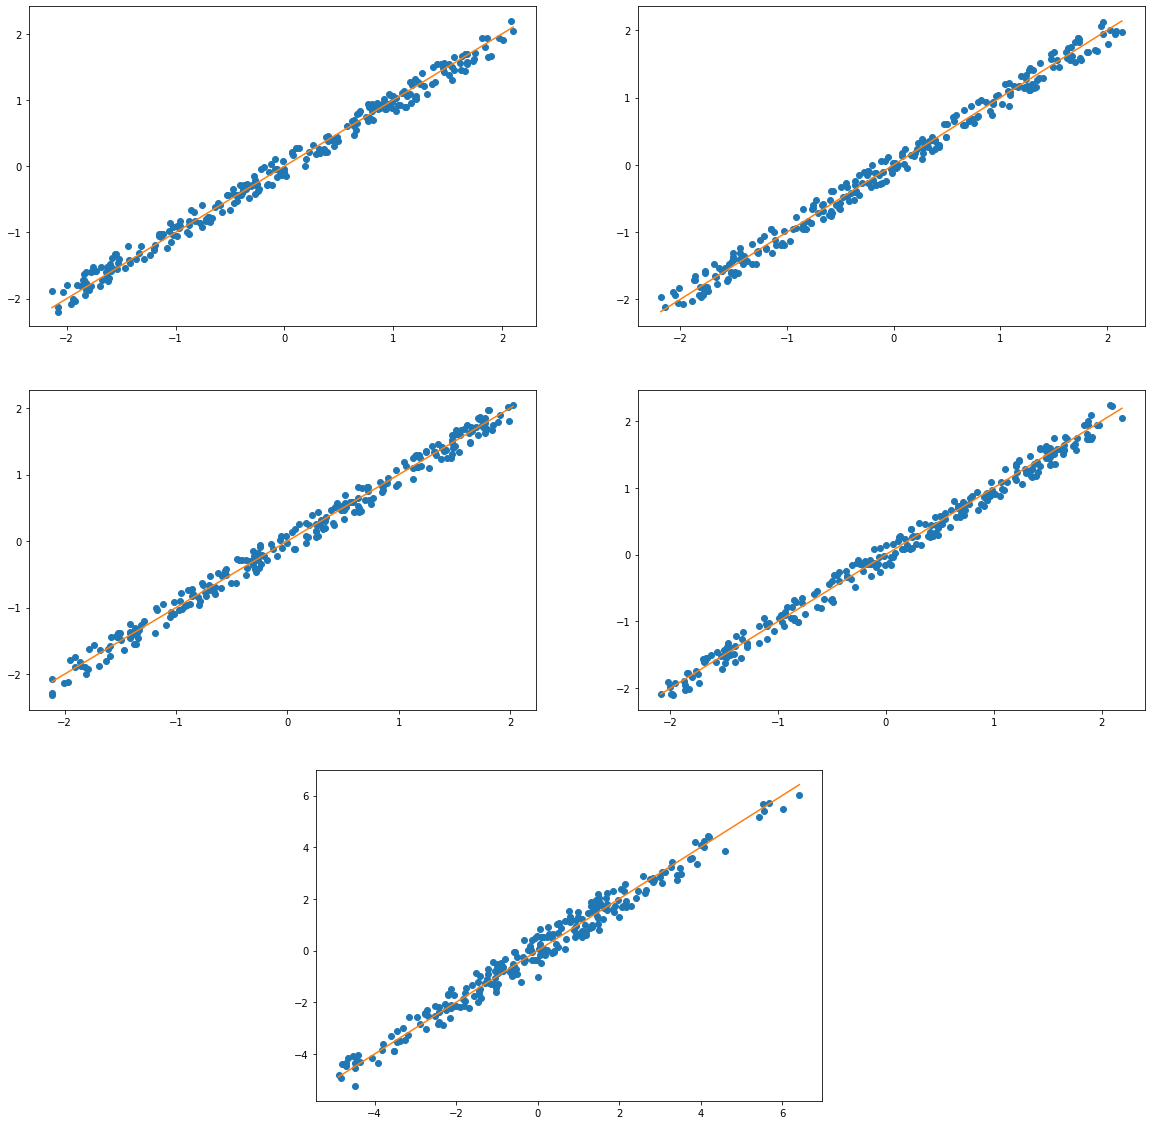

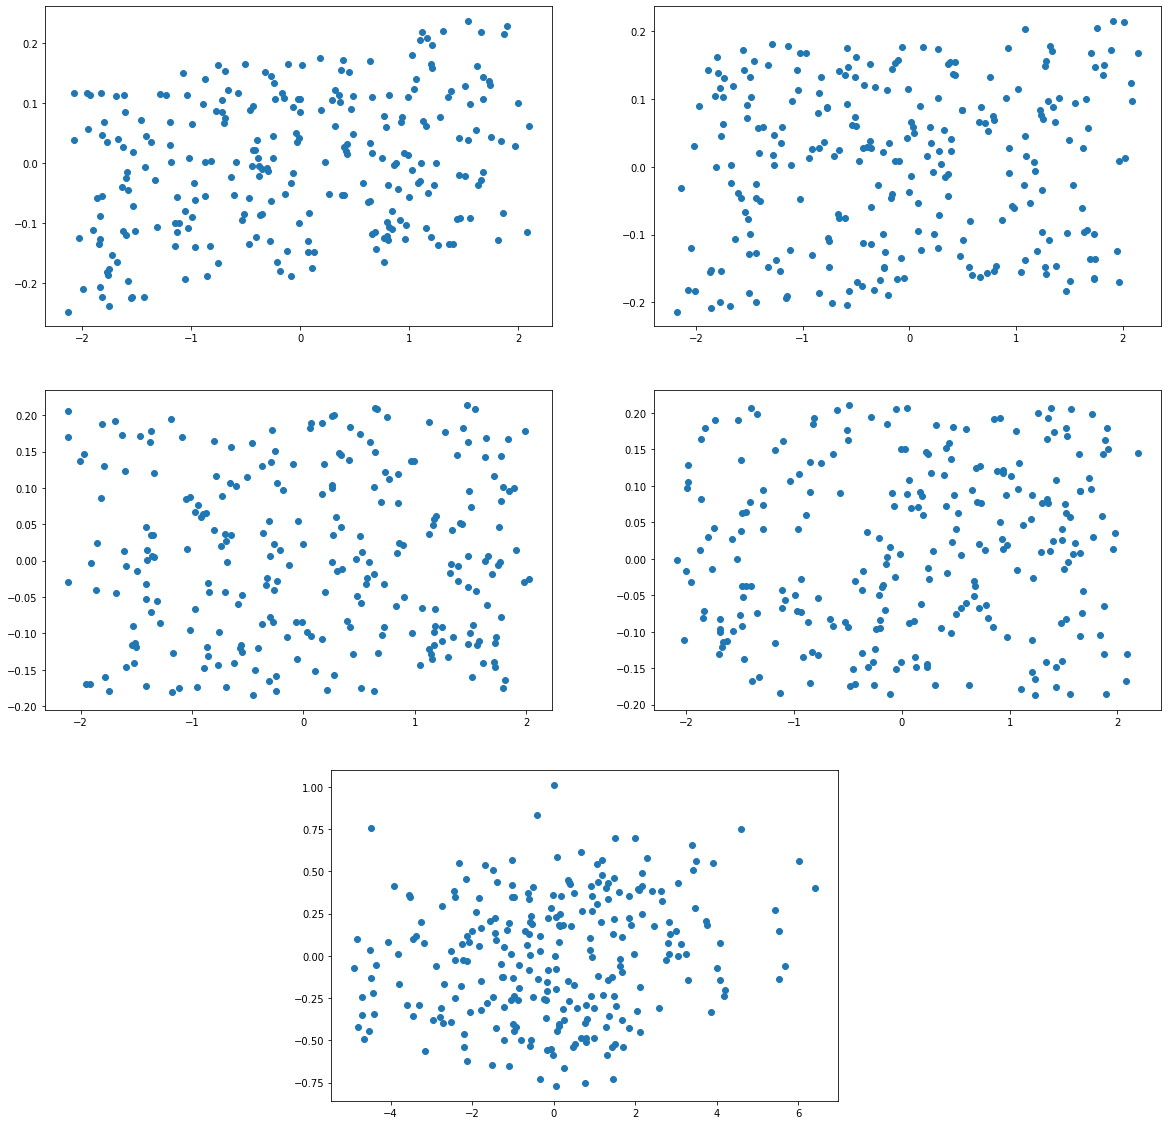

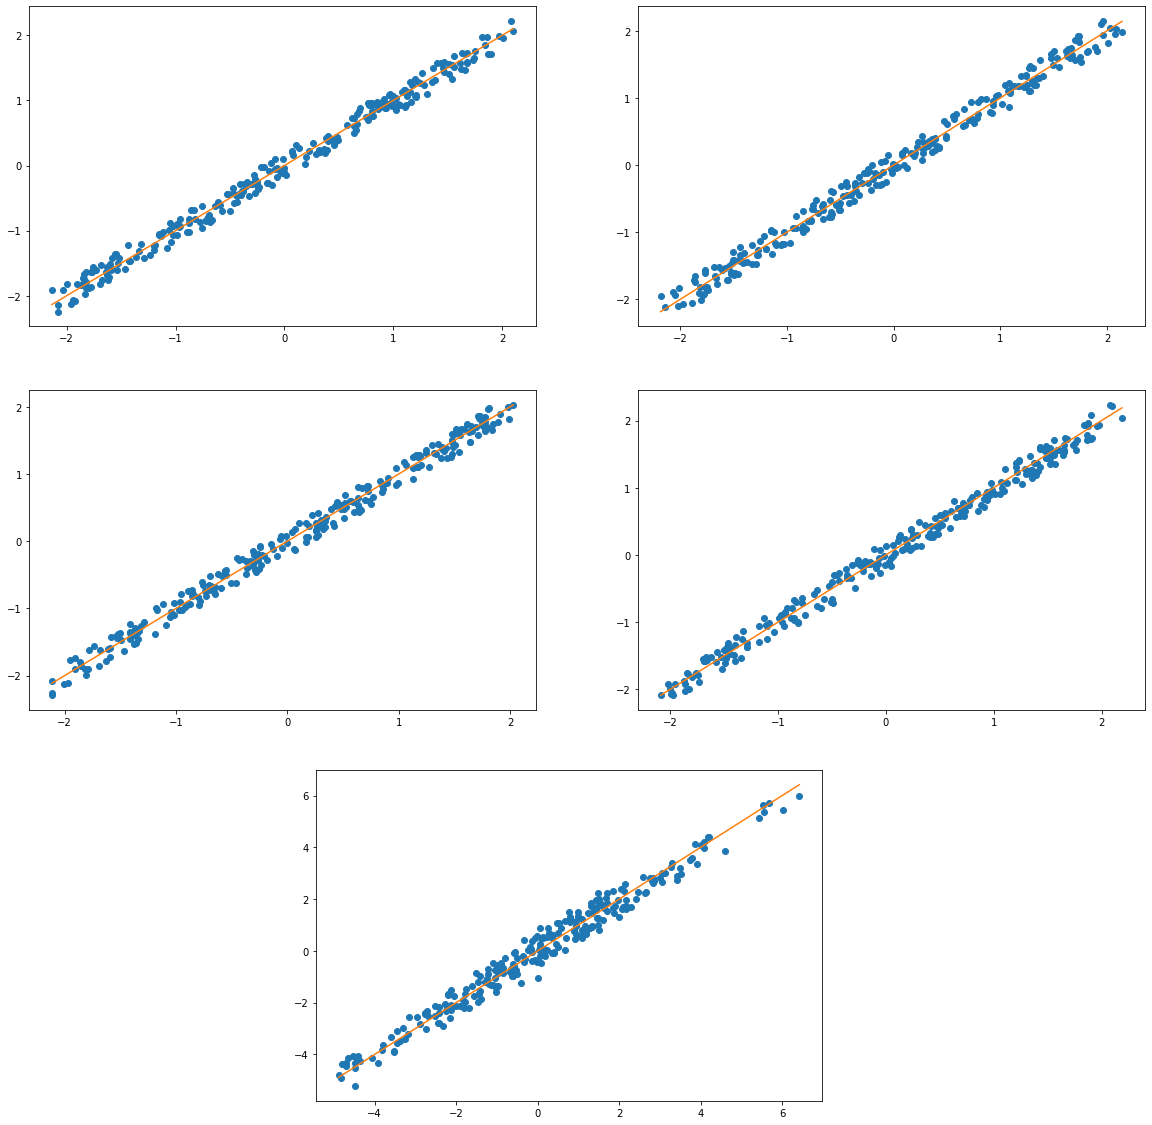

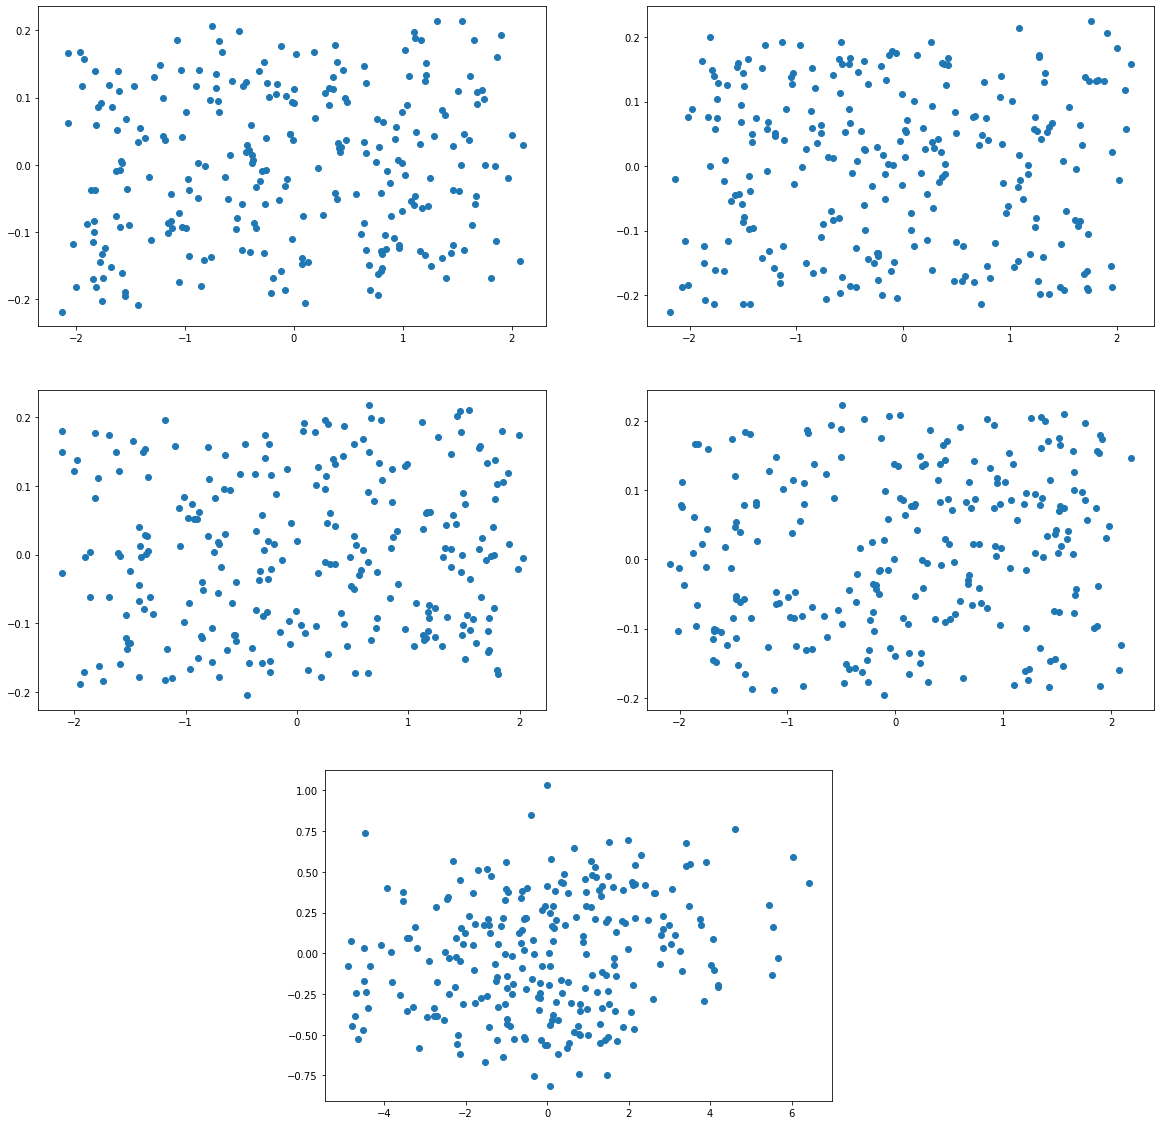

In [2]:
s, i= create_uncorrelated(global_data['exper'])
s_trad, i_trad = into_indiv_cal(s, i)
c_trad = np.linalg.inv(s_trad.T@s_trad)@ s_trad.T@i_trad
c_nueva=i@s.T@np.linalg.inv((s@s.T))
print('Calibración tradicional:\n',c_trad, '\nCalibración propuesta:\n' ,c_nueva)
s, i = create_uncorrelated(global_data['exper'])
i_hat_trad = get_measure(c_trad,s)
i_hat_nueva = c_nueva@s
plot(i_hat_trad, i)
plot(i_hat_nueva, i)

Calibración tradicional:
 [  0.01942746 -38.84550201   0.01942748 -38.85581765   0.01959886 -39.1845832    0.01977825 -39.5484163 ] 
Calibración propuesta:
 [[  0.01496583   0.00000442  -0.00302619  -0.00297985 -17.93051932]
 [  0.00161077   0.01553985   0.00350273  -0.00332008 -34.66194164]
 [ -0.00292372   0.00310869   0.01615329   0.00136074 -35.38842027]
 [ -0.00348189  -0.00396261   0.00033843   0.01374639 -13.27157734]
 [  0.00366843  -0.0120044   -0.00994182   0.00228089  31.99554107]]


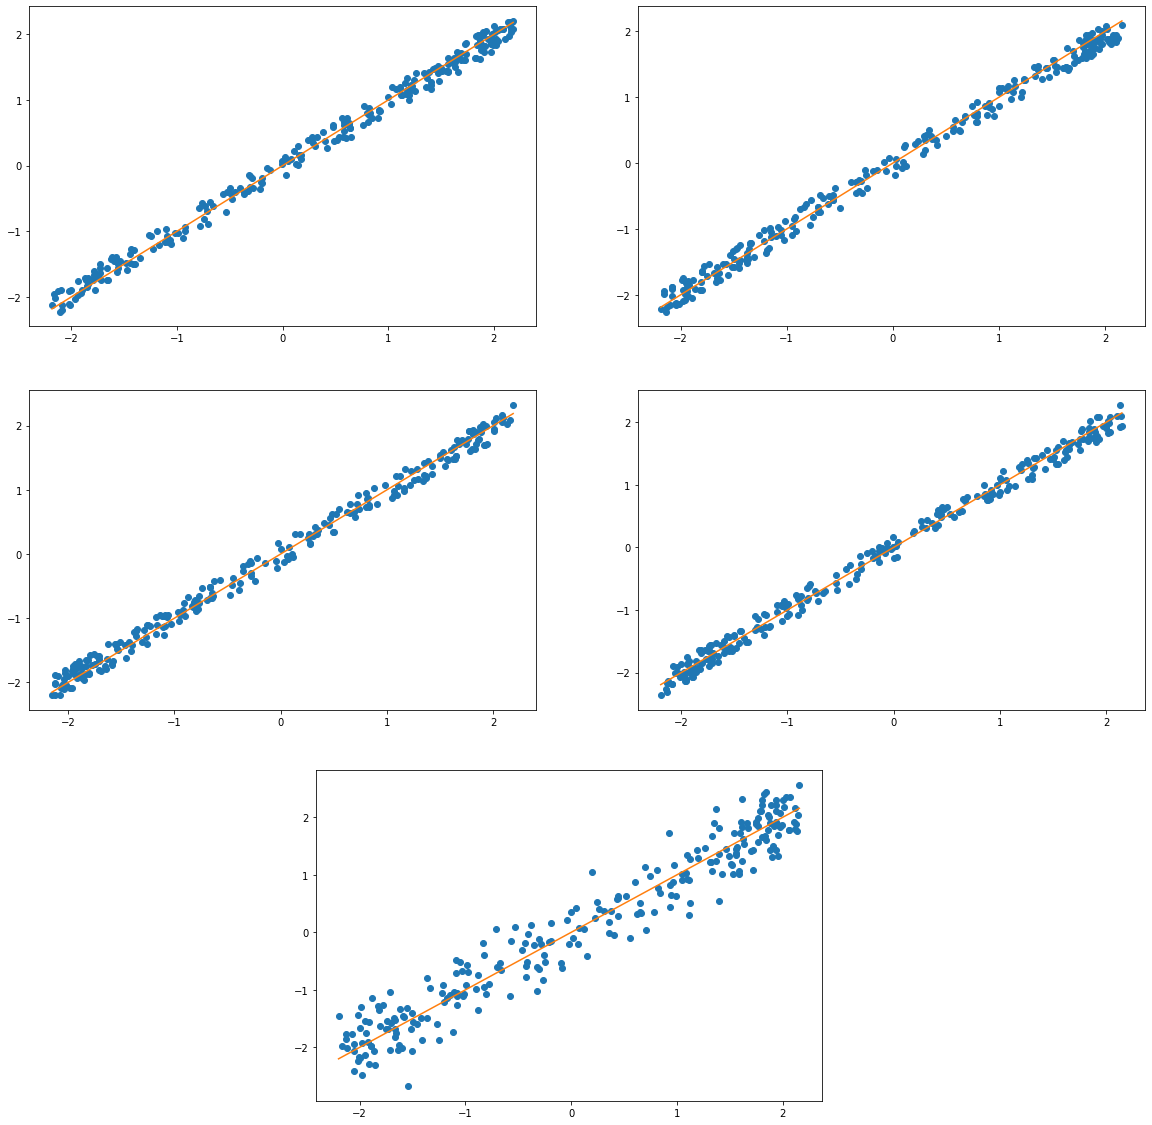

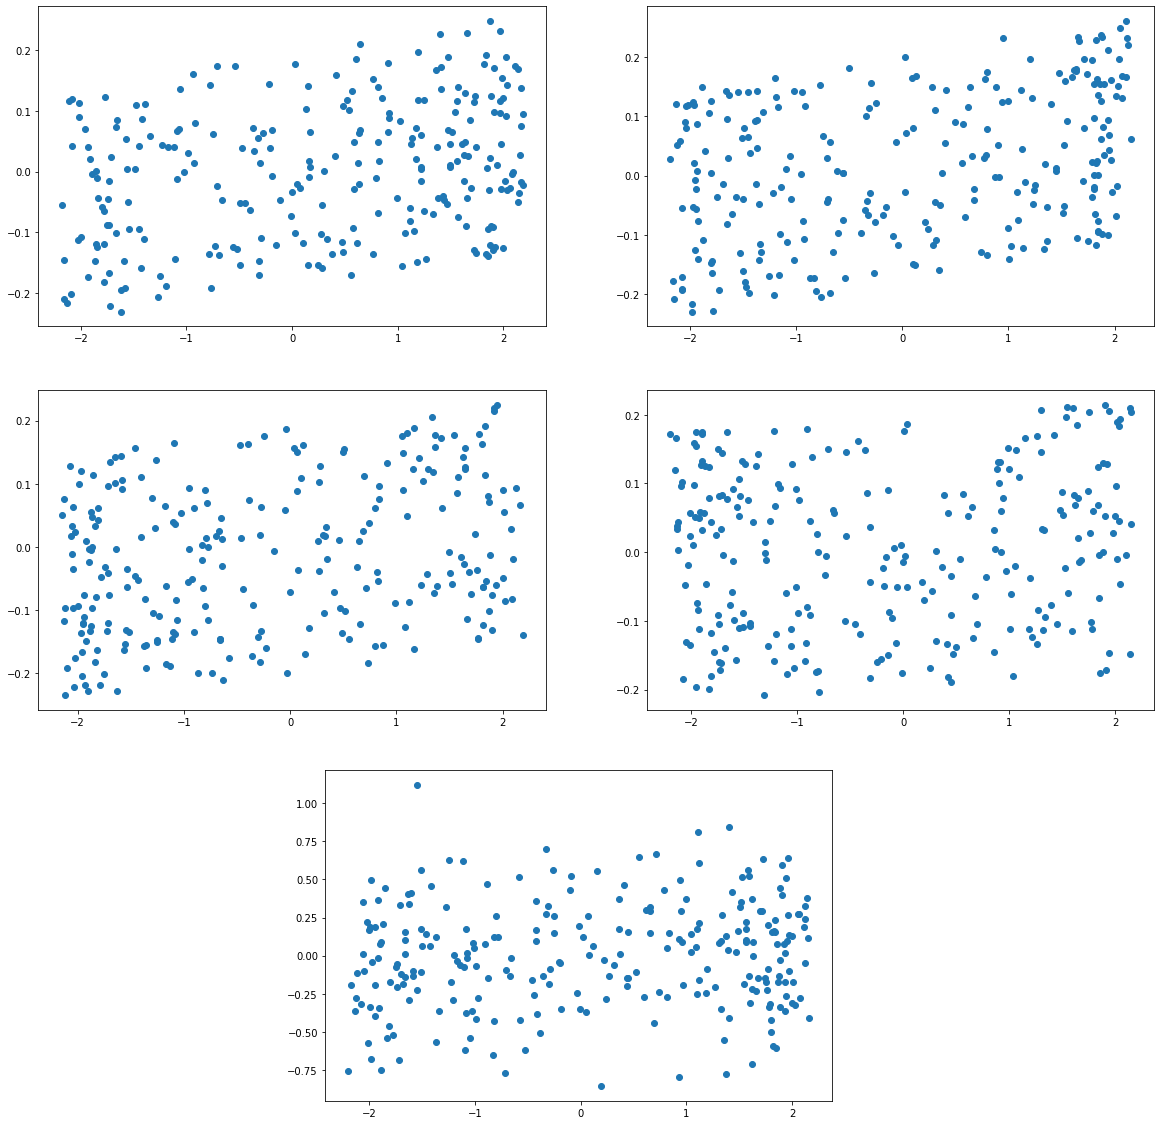

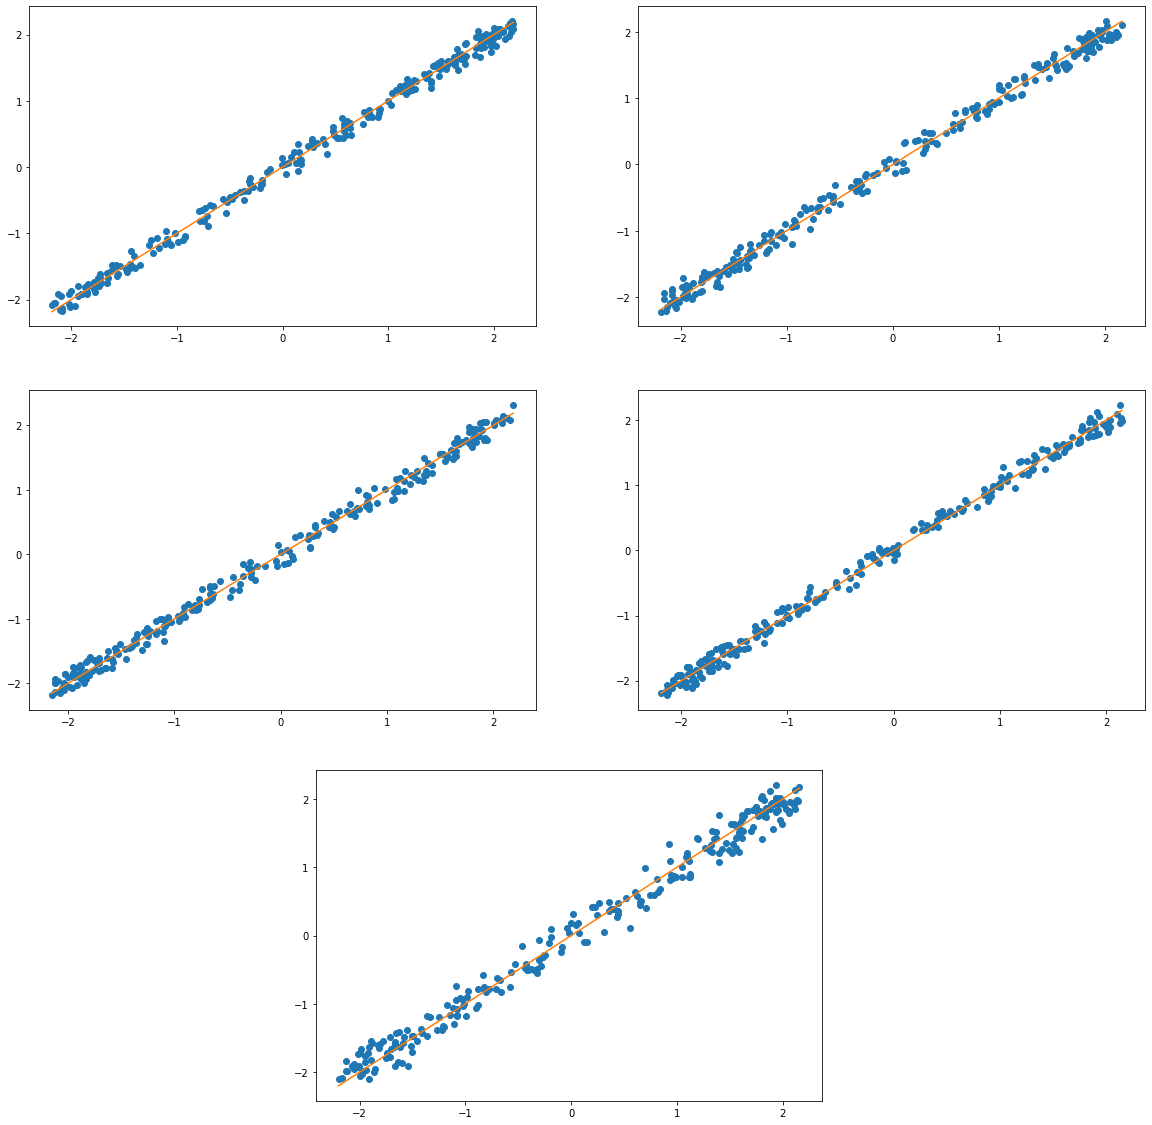

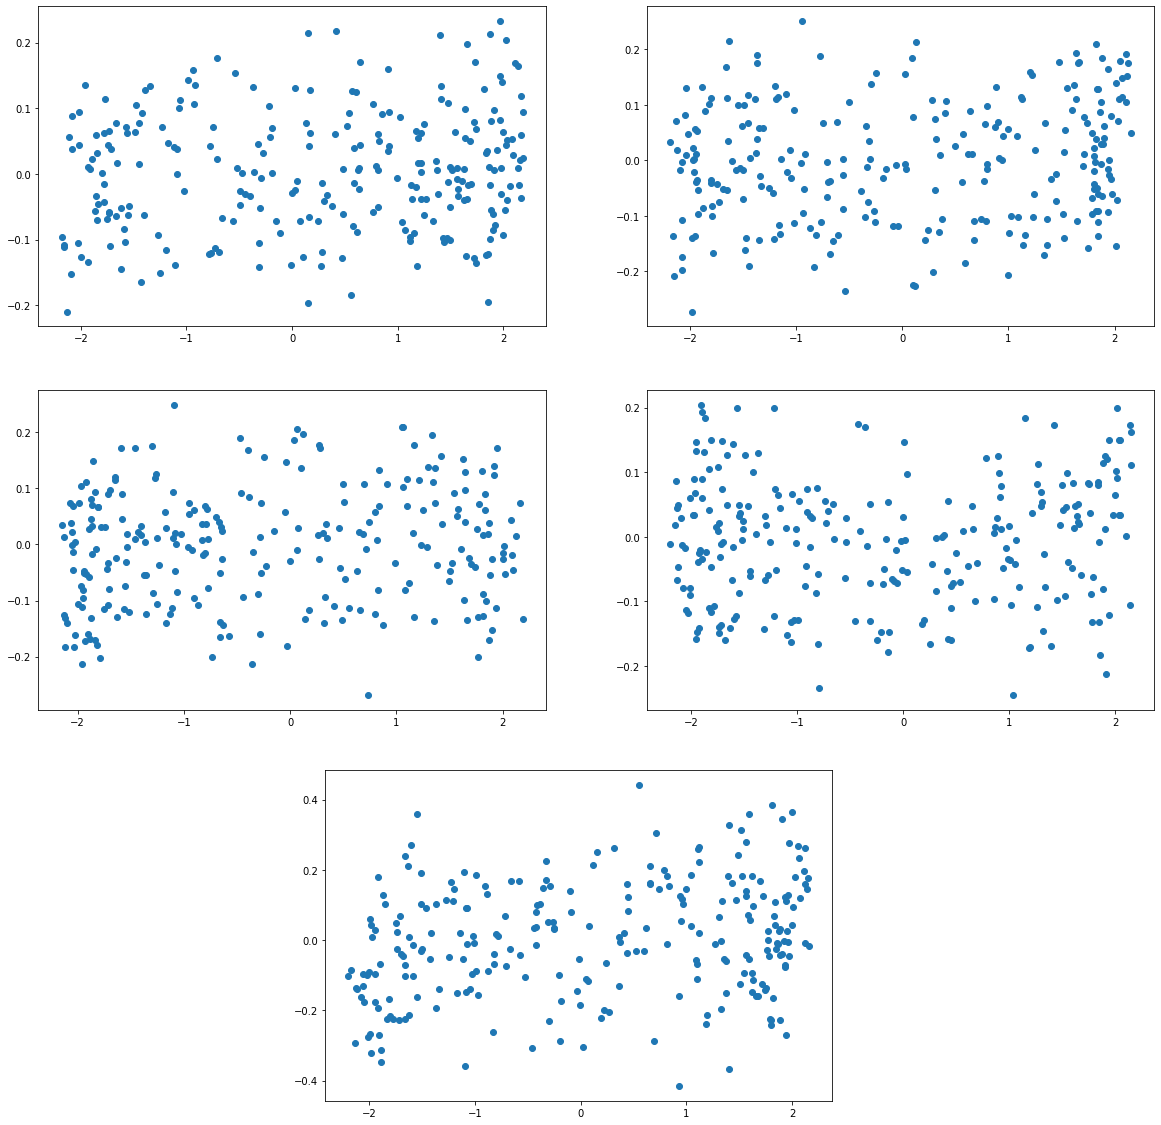

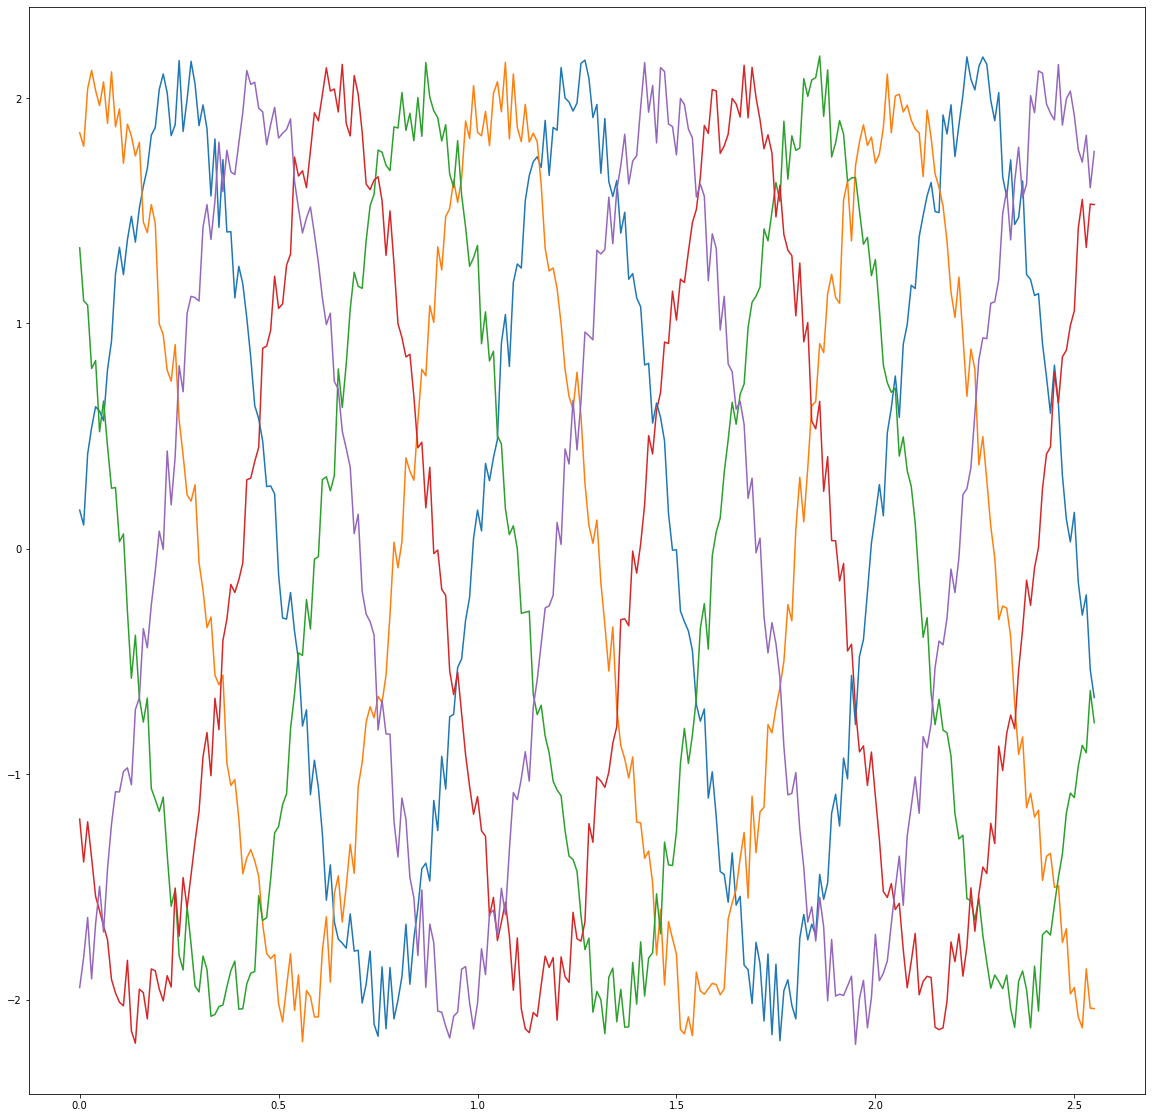

In [3]:
s, i= create_sine(global_data['exper'])
s_trad, i_trad = into_indiv_cal(s, i)
c_trad = np.linalg.inv(s_trad.T@s_trad)@ s_trad.T@i_trad
c_nueva=i@s.T@np.linalg.inv((s@s.T))
print('Calibración tradicional:\n',c_trad, '\nCalibración propuesta:\n' ,c_nueva)
s, i = create_sine(global_data['exper'])
i_hat_trad = get_measure(c_trad,s)
i_hat_nueva = c_nueva@s
plot(i_hat_trad, i)
plot(i_hat_nueva, i)
plot_intens(i)

## Conclusión

En general, la calibración es muy similar, pero mejora en la fase no medida en el caso en el que las medidas están correladas. Esta mejora se debe a que se calibra independientemente y sin coste para las otras fases.